In [28]:
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import numpy as np


def lotka_volterra(vars, t, *params):
    alpha, beta, delta, gamma, epsilon, eta, zeta = params
    x, y, z = vars
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y - epsilon * y * z
    dzdt = eta * y * z - zeta * z
    return [dxdt, dydt, dzdt]


# model to return values of the system at samples_t points in time for given params
def lotka_volterra_sampler(
    samples_t,
    *params,
):

    alpha, beta, delta, gamma, epsilon, eta, zeta, x0, y0, z0 = params

    initial_values = [x0, y0, z0]

    response_y = np.zeros((len(samples_t), len(initial_values)))

    for i in np.arange(0, len(samples_t)):
        if samples_t[i] == 0.0:  # should include a decimal
            response_y[i, :] = np.array(initial_values)
        else:
            t_span = np.linspace(0.0, samples_t[i], 100)
            ySoln = odeint(
                lotka_volterra, initial_values, t_span, args=tuple(params[:-3])
            )
            response_y[i, :] = ySoln[-1, :]

    return np.ravel(np.transpose(response_y))

Create time samples in range 0 to 5.

In [29]:
# create an axis to make some samples
t_axis = np.linspace(0, 30, 6001)
axis_for_plotting = np.linspace(0, t_axis[-1], t_axis.shape[0])

Define a reference system that we'll try to retrieve from different parameters.

In [30]:
correct_params = np.array(
    [5.0, 0.002, 0.0007, 1.0, 0.0001, 0.0008, 2.0, 50.0, 35.0, 10.0]
)
y_correct = odeint(
    lotka_volterra,
    correct_params[-3:],
    axis_for_plotting,
    args=tuple(correct_params[:-3]),
)

x1, y1, z1 = y_correct[:, 0], y_correct[:, 1], y_correct[:, 2]

Create a model with roughly estimated parameters that could describe the original

In [45]:
starting_params = np.array(
    [5.1, 0.0021, 0.0007, 1.1, 0.00011, 0.000801, 2.01, 50.0, 34.95, 10.1]
)
y_tarting = odeint(
    lotka_volterra,
    starting_params[-3:],
    axis_for_plotting,
    args=tuple(starting_params[:-3]),
)

x2, y2, z2 = y_tarting[:, 0], y_tarting[:, 1], y_tarting[:, 2]

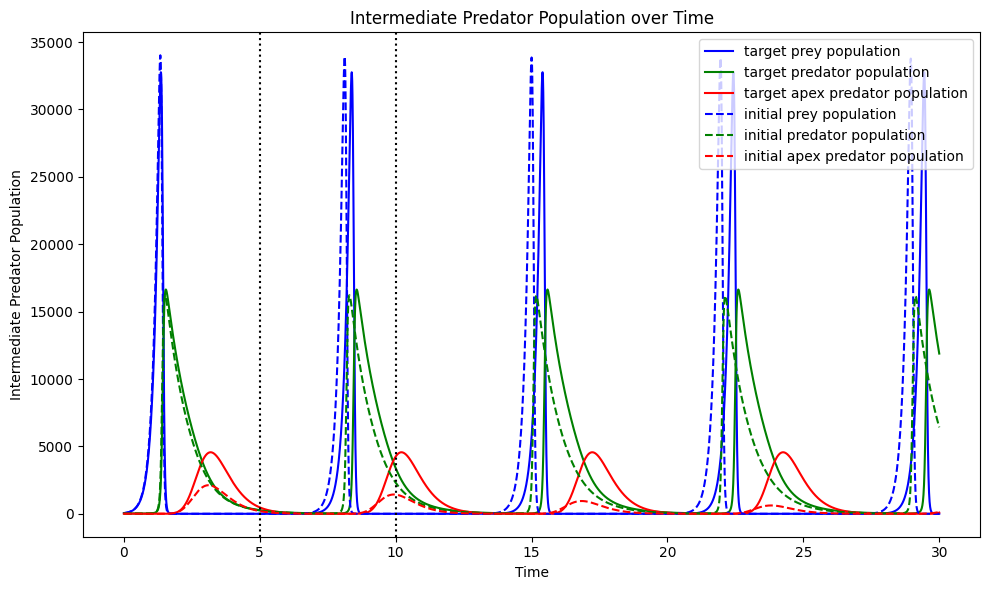

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(t_axis, x1, lw=1.5, color="b", label="target prey population")

ax.plot(t_axis, y1, lw=1.5, color="g", label="target predator population")

ax.plot(
    t_axis,
    z1,
    lw=1.5,
    color="r",
    label="target apex predator population",
)

ax.plot(
    t_axis, x2, lw=1.5, color="b", label="initial prey population", linestyle="dashed"
)

ax.plot(
    t_axis,
    y2,
    lw=1.5,
    color="g",
    label="initial predator population",
    linestyle="dashed",
)

ax.plot(
    t_axis,
    z2,
    lw=1.5,
    color="r",
    label="initial apex predator population",
    linestyle="dashed",
)

plt.axvline(x=5, color="black", linestyle="dotted")
plt.axvline(x=10, color="black", linestyle="dotted")


ax.set_title("Intermediate Predator Population over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Intermediate Predator Population")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

Fit the parameters of the new model using a few samples from the original model's response

In [47]:
sampling_idx = np.arange(0, 3001, 100)[20:31]
t_samples = t_axis[sampling_idx]
y_samples = np.ravel(np.transpose(y_correct[sampling_idx]))

predicted_params, _ = curve_fit(
    lotka_volterra_sampler, t_samples, y_samples, p0=starting_params
)
y_prediction = odeint(
    lotka_volterra,
    predicted_params[-3:],
    axis_for_plotting,
    args=tuple(predicted_params[:-3]),
)

In [48]:
import pandas as pd

param_names = [
    "alpha",
    "beta",
    "delta",
    "gamma",
    "epsilon",
    "eta",
    "zeta",
    "x0",
    "y0",
    "z0",
]

df_params = pd.DataFrame(index=param_names)
df_params["starting"] = starting_params
df_params["predicted"] = predicted_params
df_params["target"] = correct_params
df_params

,starting,predicted,target
alpha,5.100000,5.674705,5.0000
beta,0.002100,0.002195,0.0020
delta,0.000700,0.000657,0.0007
gamma,1.100000,0.897529,1.0000
epsilon,0.000110,0.000086,0.0001
eta,0.000801,0.000744,0.0008
zeta,2.010000,1.915950,2.0000
x0,50.000000,54.565673,50.0000
y0,34.950000,51.976112,35.0000
z0,10.100000,11.449812,10.0000


Predicted parameter values

In [49]:
np.abs(correct_params - predicted_params)

array([6.74705281e-01, 1.94883061e-04, 4.30948822e-05, 1.02470990e-01,
       1.43216832e-05, 5.60628728e-05, 8.40502033e-02, 4.56567288e+00,
       1.69761120e+01, 1.44981242e+00])

MSE for predicted dynamic variables

In [50]:
np.square(y_correct - y_prediction).sum() / np.prod(y_prediction.shape)

np.float64(2914562.013043878)

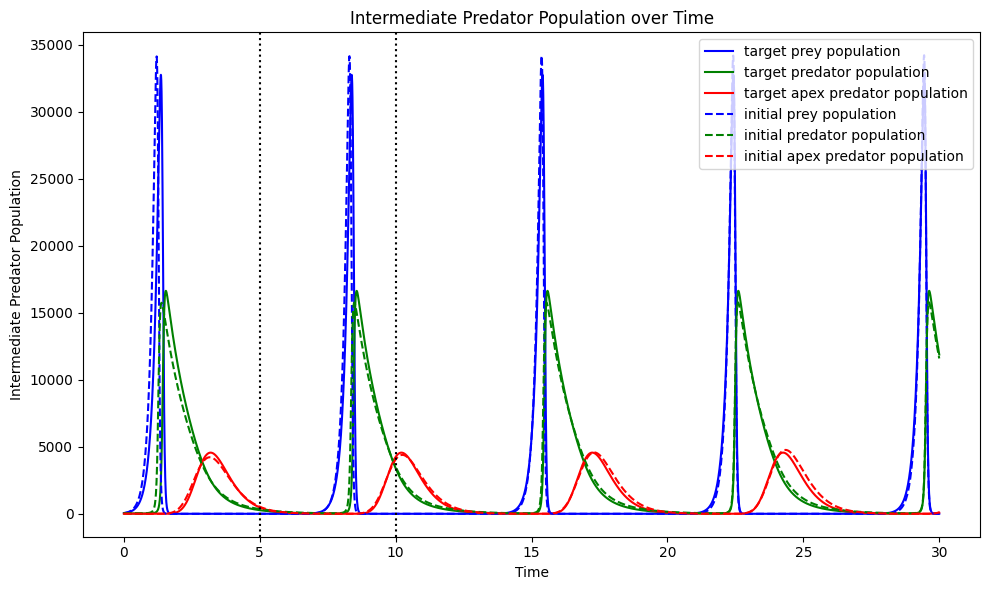

In [51]:
import matplotlib.pyplot as plt

x3, y3, z3 = y_prediction[:, 0], y_prediction[:, 1], y_prediction[:, 2]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(t_axis, x1, lw=1.5, color="b", label="target prey population")

ax.plot(t_axis, y1, lw=1.5, color="g", label="target predator population")

ax.plot(
    t_axis,
    z1,
    lw=1.5,
    color="r",
    label="target apex predator population",
)

ax.plot(
    t_axis, x3, lw=1.5, color="b", label="initial prey population", linestyle="dashed"
)

ax.plot(
    t_axis,
    y3,
    lw=1.5,
    color="g",
    label="initial predator population",
    linestyle="dashed",
)

ax.plot(
    t_axis,
    z3,
    lw=1.5,
    color="r",
    label="initial apex predator population",
    linestyle="dashed",
)

plt.axvline(x=5, color="black", linestyle="dotted")
plt.axvline(x=10, color="black", linestyle="dotted")

ax.set_title("Intermediate Predator Population over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Intermediate Predator Population")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

We managed to fit the model locally to model the original function